<a href="https://colab.research.google.com/github/Saibhossain/visual-Transformers_-ViT-/blob/main/ViT_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Vision Transformer (ViT) is a deep learning architecture that applies the Transformer model (originally from NLP) to image understanding. It replaces convolutions with self-attention, allowing global context modeling from the start. ViT solves several CNN limitations such as limited receptive fields, inductive bias rigidity, and inefficiency in scaling with massive datasets.

# problem in cnn

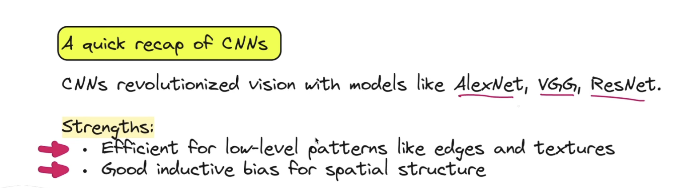

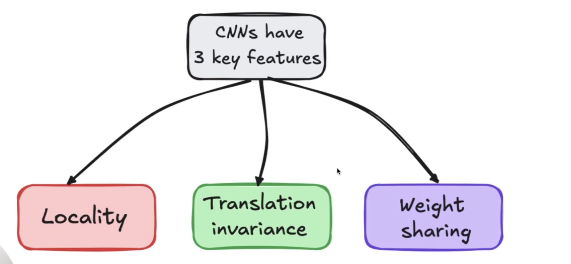

| Aspect                | CNN                              | ViT                                       |
| --------------------- | -------------------------------- | ----------------------------------------- |
| Spatial modeling      | Local → progressively global     | Global from first layer (self-attention)  |
| Inductive bias        | Strong (locality, translation)   | Weak; more flexible                       |
| Data requirement      | Works well on small datasets     | Needs large datasets or good pretraining  |
| Architecture          | Conv layers + pooling            | Patch embeddings + Transformer encoder    |
| Computational scaling | Hard to scale very deep          | Scales well with model size               |
| Interpretability      | Filters highlight local features | Self-attention maps show global relations |


1. What is a Vision Transformer (ViT)?
> A Vision Transformer is an image recognition model that treats an image as a sequence of patches (like words in a sentence) and processes them with Transformer layers using self-attention instead of convolutions.
Key idea: Convert image → fixed-size patches → linear embeddings → Transformer encoder → classification.

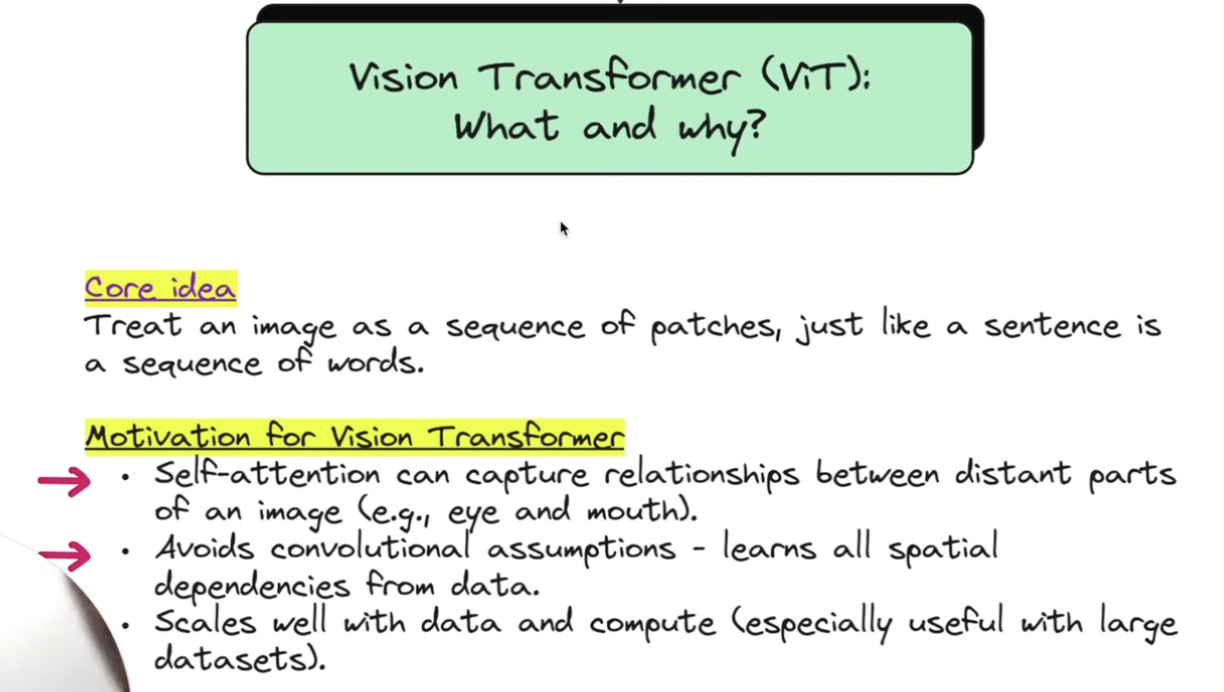

2. How does ViT work?
> Core steps:
> Step 1: Patch Creation
The image (e.g., 224×224×3) is split into small patches (e.g., 16×16).
Each patch is flattened into a vector.

> Step 2: Patch Embeddings
Each flattened patch is fed through a linear layer to produce a fixed-dimension embedding.
This produces a sequence (like words in NLP).

>Step 3: Positional Embeddings
Since Transformers do not understand spatial order, learnable positional embeddings are added.

>Step 4: Transformer Encoder
Multi-Head Self-Attention (MHSA) lets every patch “see” every other patch from the first layer.
Feedforward layers refine the representation.

>Step 5: Classification
A special learnable token (CLS token) aggregates global information.
Final MLP classifies the image.

# implementation

## simple Vision Transformers



> Below is a clean, minimal, beginner-friendly PyTorch implementation of a Vision Transformer (ViT). It includes patch embedding, positional encoding, Transformer encoder blocks, and a classifier head. The code is intentionally simple and readable so you can learn the core mechanics.



In [2]:
import torch
import torch.nn as nn

# -----------------------------
# 1. Patch Embedding Layer
# -----------------------------
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, embed_dim=768):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # A conv layer with stride==patch_size works as a patch extractor
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Output shape: (B, embed_dim, H/ps, W/ps)
        x = self.proj(x)                         # B, embed_dim, num_patches_h, num_patches_w
        x = x.flatten(2)                         # B, embed_dim, num_patches
        x = x.transpose(1, 2)                    # B, num_patches, embed_dim
        return x


# -----------------------------
# 2. Multi-Head Self Attention
# -----------------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)      # q: B, heads, N, head_dim

        attn = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = attn.softmax(dim=-1)

        out = attn @ v                            # B, heads, N, head_dim
        out = out.transpose(1, 2).reshape(B, N, C)
        return self.proj(out)


# -----------------------------
# 3. Transformer Encoder Block
# -----------------------------
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))          # Residual connection
        x = x + self.mlp(self.norm2(x))
        return x


# -----------------------------
# 4. Vision Transformer (ViT)
# -----------------------------
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_ch=3,
        num_classes=1000,
        embed_dim=768,
        depth=12,
        num_heads=12
    ):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_ch, embed_dim)
        num_patches = self.patch_embed.num_patches

        # CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Positional embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        # Transformer layers
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads) for _ in range(depth)
        ])

        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]

        # Generate patch embeddings
        x = self.patch_embed(x)

        # Add CLS token
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Add positional embeddings
        x = x + self.pos_embed

        # Transformer encoder
        for layer in self.layers:
            x = layer(x)

        # Classification (use CLS token output)
        x = self.norm(x)
        cls_output = x[:, 0]

        return self.head(cls_output)


# -----------------------------
# 5. Test run (forward pass)
# -----------------------------
if __name__ == "__main__":
    model = VisionTransformer(
        img_size=224,
        patch_size=16,
        num_classes=10,   # example: CIFAR-10 style
        embed_dim=256,
        depth=6,
        num_heads=8
    )

    x = torch.randn(2, 3, 224, 224)    # batch of 2 images
    logits = model(x)
    print(logits.shape)                # Expected: (2, 10)
    print(model.eval())

torch.Size([2, 10])
VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (layers): ModuleList(
    (0-5): 6 x TransformerEncoderBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=10, bias=True)
)
